Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tempfile
import random

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

In [4]:
print(tf.version.VERSION)

2.12.0


Loading dataset generated from Tangent Plane Distance calculations done in PhasePY

In [5]:
filename = 'Case1_tpd_calc_slle.csv'

In [6]:
raw_dataset = pd.read_csv(filename, header=0)

In [7]:
dataset = raw_dataset.copy()
dataset = dataset.dropna()

In [8]:
ds1 = dataset.drop(columns=['Unnamed: 0','Solvent 1','Solvent 2','T'])

Partitioning the dataset into training, validation and testing by randomly splitting it. The seed used for randomly splitting the dataset is fixed!

In [9]:
def get_dataset_partitions_tf(df, train_split=0.7, val_split=0.15, test_split=0.15):
    assert (train_split + test_split + val_split) == 1
    assert val_split == test_split
    
    df_sample = df.sample(frac=1, random_state=12)
    
    indices_or_sections = [int(train_split * len(df)), int((1 - val_split - test_split) * len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    
    return train_ds, val_ds, test_ds

In [10]:
train, val, test = np.split(ds1.sample(frac=1, random_state=12), [int(0.7*len(ds1)), int(0.85*len(ds1))])

Quick inspection of the data

In [11]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'testing examples')

12898 training examples
2764 validation examples
2765 testing examples


In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
q1,12898.0,2.583560,0.764740,1.432000,2.336000,2.588000,3.124000,3.952000
q2,12898.0,2.594872,0.785821,1.400000,2.336000,2.588000,3.116000,3.952000
r1,12898.0,2.789122,0.944430,1.431100,2.573500,2.575500,3.249100,4.595900
r2,12898.0,2.896337,1.214561,0.920000,2.573500,2.870000,3.922800,4.595900
x1,12898.0,0.333398,0.180022,0.002125,0.202478,0.334565,0.452309,0.983901
x2,12898.0,0.334021,0.180257,0.001941,0.199875,0.333955,0.442793,0.995602
ismisc,12898.0,0.865483,0.341220,0.000000,1.000000,1.000000,1.000000,1.000000


Segregating the features (inputs) and labels (outputs) from the dataset

In [13]:
train_features = train.copy()
test_features = test.copy()
val_features = val.copy()
train_lab = train_features.pop('ismisc')
test_lab = test_features.pop('ismisc')
val_lab = val_features.pop('ismisc')

Normalising the training data to make it more amenable for training!

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[2.584 2.595 2.789 2.896 0.333 0.334]]


Segregating the positive and the negative labels

In [15]:
bool_train_labels = train_lab != 0
neg, pos = np.bincount(train_lab)
train_full = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    train_full, pos, 100 * pos / train_full, neg, 100 * neg / train_full))
initial_bias = np.log([pos/neg])
print(initial_bias)

Examples:
    Total: 12898
    Positive: 11163 (86.55% of total)
    Negative: 1735 (13.45% of total)

[1.862]


In [16]:
BATCH_SIZE = 114
STEPS_PER_EPOCH = len(train)/BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.03,
    decay_steps=STEPS_PER_EPOCH*10,
    decay_rate=1,
    staircase=False
)

In [17]:
def build_and_compile_model_single_layer(norm,num_neurons,activation='tanh',output_bias=None,seed_value=None):
    if seed_value is not None:
        #random.seed(seed_value)
        #np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        if activation =='relu':
            kernel_initializer = tf.keras.initializers.he_normal()
        else:
            kernel_initializer = tf.keras.initializers.glorot_uniform()
    if activation =='relu':
        kernel_initializer = 'he_normal'
    else:
        kernel_initializer = 'glorot_uniform'
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    #kernel_regularizer = tf.keras.regularizers.l2(l=0.0001)
    
    model = keras.Sequential([
        norm,
        layers.Dense(num_neurons, activation=activation, 
                     kernel_initializer=kernel_initializer, kernel_regularizer=None),
        layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer, bias_initializer=output_bias)
    ])
    
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(lr_schedule),
                 metrics = [
        tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        #tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
        #tf.keras.metrics.AUC(name='AUC'),
        #tf.keras.metrics.AUC(name='prc', curve='PR'),
            ]
                 )
    return model

In [18]:
def neurons_upper_bound(num_train, num_inputs, num_outputs):
    num_train_eq = num_train * num_outputs
    num_neurons_ub = -1 + math.ceil((num_train_eq - num_outputs)/(num_inputs + num_outputs + 1))
    num_neurons_ub = math.floor(num_neurons_ub/3) #heuristic
    return num_neurons_ub

In [19]:
def get_mcc(tp,tn,fp,fn):
    prod1 = tp*tn
    prod2 = fp*fn
    sum1 = tp+fp
    sum2 = tp+fn
    sum3 = tn+fp
    sum4 = tn+fn
    if sum1 == 0 or sum2 == 0 or sum3==0 or sum4==0:
        return (prod1 - prod2)
    else:
        return (prod1 - prod2)/math.sqrt(sum1*sum2*sum3*sum4)

In [20]:
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_loss_max = max(train_loss)
    val_loss_max = max(val_loss)
    plt.plot(train_loss, label='loss')
    plt.plot(val_loss, label='val_loss')
    plt.ylim([0,0.1])
    #plt.ylim([0,min(train_loss_max,val_loss_max)])
    plt.xlabel('Epoch')
    plt.ylabel('Error [misc12]')
    plt.legend()
    plt.grid(True)

In [21]:
def iterative_training(norm, num_train, num_inputs,
                       num_outputs, activation, num_epochs, 
                       output_bias,common_seed,train_features, train_labels,
                       val_features, val_labels,
                       test_features, test_labels, tolerance):
    num_neurons_ub = neurons_upper_bound(num_train, num_inputs, num_outputs)
    mcc = {}
    max_value = 0
    for i in range(1, num_neurons_ub):
        for j in range(0,5):
            seed_value = common_seed + j
            print("Number of neurons: ",i," Trial ", j+1)
            model = build_and_compile_model_single_layer(norm,i,activation,output_bias,seed_value)
            history = model.fit(
            train_features,
            train_labels,
            batch_size = BATCH_SIZE,
            epochs = num_epochs,
            verbose = 0,
            validation_data = (val_features, val_lab)
            )
            mcc[i,j] = get_mcc(history.history['val_tp'][num_epochs-1], history.history['val_tn'][num_epochs-1], history.history['val_fp'][num_epochs-1], history.history['val_fn'][num_epochs-1])
            print(mcc[i,j])
            if (mcc[i,j] > max_value):
                max_value = mcc[i,j]
                best_model = model
                best_history = history    
        #max_value = max(mcc.values())
        print(max_value)
        if max_value >= tolerance:
            #max_key = max(mcc, key=mcc.get)
            #print(max_key)
            return best_model, best_history, max_value
            break
        else:
            continue

In [22]:
num_outputs = 1
num_inputs = len(train_features.columns) - num_outputs
num_train = len(train_features)

In [23]:
%%time
common_seed = 42
tanh_model, tanh_history, tanh_mcc = iterative_training(
    normalizer, num_train, 
    num_inputs, num_outputs,
    'tanh' , 150, initial_bias, common_seed,
    train_features, train_lab, 
    val_features, val_lab, 
    test_features, test_lab, 0.99)

Number of neurons:  1  Trial  1
0.9411202079296042
Number of neurons:  1  Trial  2
0.9377068294444125
Number of neurons:  1  Trial  3
0.9377068294444125
Number of neurons:  1  Trial  4
0.9377068294444125
Number of neurons:  1  Trial  5
0.9377068294444125
0.9411202079296042
Number of neurons:  2  Trial  1
0.9642812318324969
Number of neurons:  2  Trial  2
0.9629384329617022
Number of neurons:  2  Trial  3
0.9625175224500578
Number of neurons:  2  Trial  4
0.9642812318324969
Number of neurons:  2  Trial  5
0.9641894693200663
0.9642812318324969
Number of neurons:  3  Trial  1
0.9837670727798944
Number of neurons:  3  Trial  2
0.9853692906306346
Number of neurons:  3  Trial  3
0.9820411256212128
Number of neurons:  3  Trial  4
0.9805818969913346
Number of neurons:  3  Trial  5
0.9772114804764058
0.9853692906306346
Number of neurons:  4  Trial  1
0.9821177281971292
Number of neurons:  4  Trial  2
0.9853692906306346
Number of neurons:  4  Trial  3
0.978742904855532
Number of neurons:  4  Tri

In [24]:
print(tanh_mcc)

0.9902623530956935


In [25]:
test_results = {}
test_results['tanh_model'] = tanh_model.evaluate(
    test_features, test_lab, verbose=0
)

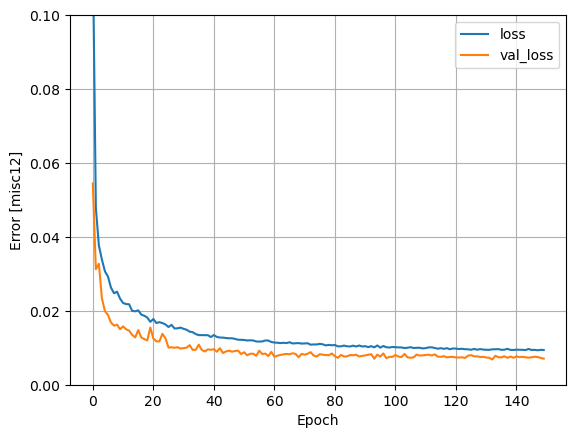

In [26]:
plot_loss(tanh_history)

In [27]:
ds2 = ds1.copy()
ismisc_full = ds2.pop('ismisc')

In [28]:
tanh_test_predictions = tanh_model.predict(test_features).flatten()
tanh_val_predictions = tanh_model.predict(val_features).flatten()
tanh_train_predictions = tanh_model.predict(train_features).flatten()
tanh_predictions = tanh_model.predict(ds2).flatten()

576/576 [==============================] - 1s 2ms/step


In [29]:
tot_neg, tot_pos = np.bincount(ismisc_full)
total_full = tot_neg + tot_pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total_full, tot_pos, 100 * tot_pos / total_full, tot_neg, 100 * tot_neg / total_full))

Examples:
    Total: 18427
    Positive: 15962 (86.62% of total)
    Negative: 2465 (13.38% of total)



In [30]:
bool_labels = ismisc_full != 0

In [31]:
pos_pred = pd.DataFrame(tanh_predictions[bool_labels])
neg_pred = pd.DataFrame(tanh_predictions[~bool_labels])

(array([    5.,     1.,     1.,     3.,     3.,     3.,     7.,     1.,
            2.,     5.,     5.,     4.,     8.,     7.,    12.,    11.,
           19.,    20.,    49., 15796.]),
 array([0.01 , 0.06 , 0.109, 0.159, 0.208, 0.258, 0.307, 0.357, 0.406,
        0.456, 0.505, 0.555, 0.604, 0.654, 0.703, 0.753, 0.802, 0.852,
        0.901, 0.951, 1.   ]),
 <BarContainer object of 20 artists>)

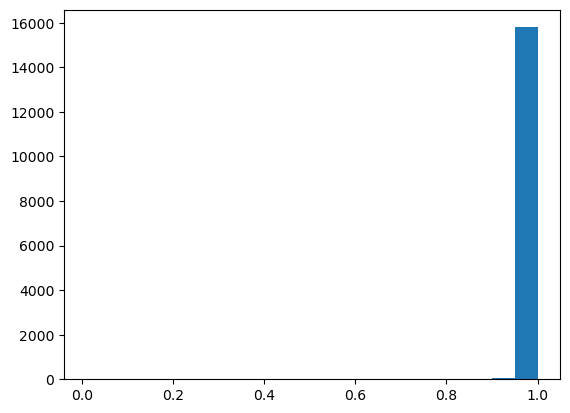

In [32]:
plt.hist(pos_pred,20)

(array([2207.,   88.,   48.,   37.,   19.,    6.,   13.,   11.,    7.,
           6.,    6.,    5.,    3.,    1.,    4.,    1.,    1.,    0.,
           0.,    2.]),
 array([0.   , 0.046, 0.092, 0.138, 0.184, 0.23 , 0.276, 0.322, 0.368,
        0.414, 0.46 , 0.506, 0.552, 0.598, 0.644, 0.69 , 0.736, 0.782,
        0.828, 0.874, 0.92 ]),
 <BarContainer object of 20 artists>)

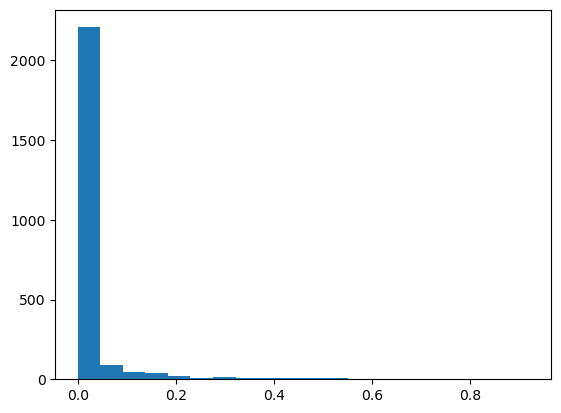

In [33]:
plt.hist(neg_pred,20)

In [34]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Immiscible samples correctly classified (True Negatives): ', cm[0][0])
    print('Immiscible samples incorrectly classified (False Positives): ', cm[0][1])
    print('Miscible samples incorrectly classified (False Negatives): ', cm[1][0])
    print('Miscible samples correctly classified (True Positives): ', cm[1][1])
    print('Total Miscible samples: ', np.sum(cm[1]))
    return cm

In [35]:
pd_predictions = pd.Series(tanh_predictions)

In [36]:
pd_predictions.describe()

count    1.842700e+04
mean     8.664580e-01
std      3.345188e-01
min      1.320574e-11
25%      9.999992e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [37]:
np.histogram(tanh_predictions)

(array([ 2310,    88,    28,    31,    21,    18,    20,    24,    40,
        15847], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

<Axes: ylabel='Frequency'>

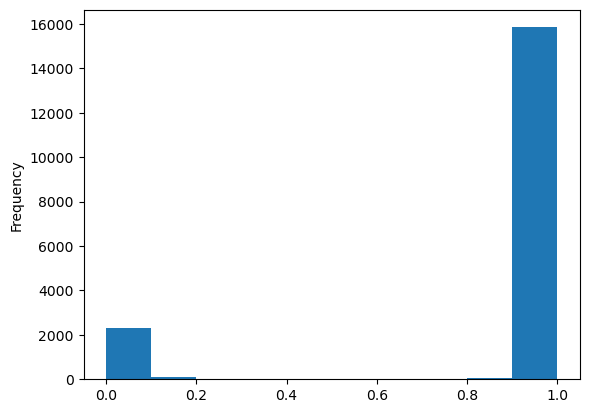

In [38]:
pd_predictions.plot(kind='hist')

<Axes: ylabel='Frequency'>

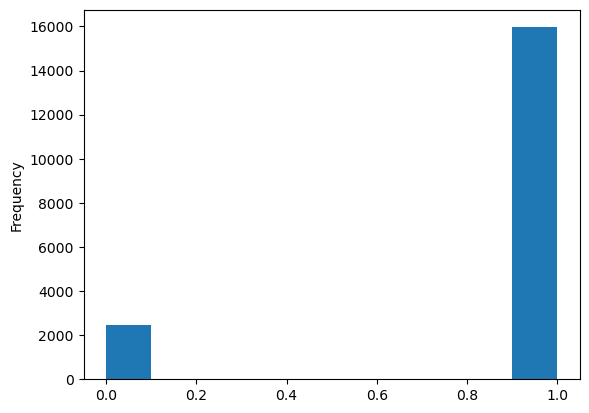

In [39]:
pd_ismisc = pd.Series(ismisc_full)
pd_ismisc.plot(kind='hist')

In [40]:
from sklearn.metrics import confusion_matrix 

In [41]:
def classifier_performance(num_points, predictions, lab):
    p = np.arange(0,1,1/num_points)
    precision = np.empty([num_points,])
    recall = np.empty([num_points,])
    accuracy = np.empty([num_points,])
    f1score = np.empty([num_points,])
    mcc = np.empty([num_points,])
    for indexp, pi in np.ndenumerate(p):
        cm = confusion_matrix(lab, predictions > pi)
        precision[indexp] = (cm[1][1]/(cm[1][1] + cm[0][1]))
        recall[indexp] = (cm[1][1]/(cm[1][1] + cm[1][0]))
        accuracy[indexp] = ((cm[1][1]+cm[0][0])/(cm[1][1] + cm[1][0] + cm[0][0] + cm[0][1]))
        f1score[indexp] = (2*precision[indexp]*recall[indexp]/(precision[indexp] + recall[indexp]))
        mcc[indexp] = get_mcc(cm[1][1],cm[0][0],cm[0][1],cm[1][0])
    return p, precision, recall, accuracy, f1score, mcc

In [42]:
def plot_performance(p,prec, rec, acc, f1score, mcc):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    
    ax1.plot(p,prec, color='r', label='precision')
    ax1.plot(p,rec, color='b', label='recall')
    ax1.plot(p,acc, color='black', label='accuracy')
    ax1.set_ylabel('Metric value')
    ax1.set_xlabel('Probability')
    ax1.set_xticks(np.arange(0,1,0.1))
    ax1.legend()
    
    ax = ax2.twinx()
    ax2.plot(p,f1score, color='orange', label='F1 score')
    ax.plot(p,mcc, color='black', label='MCC')
    ax2.set_ylabel('Metric value')
    ax2.set_xlabel('Probability')
    ax1.set_xticks(np.arange(0,1,0.1))
    plt.show()

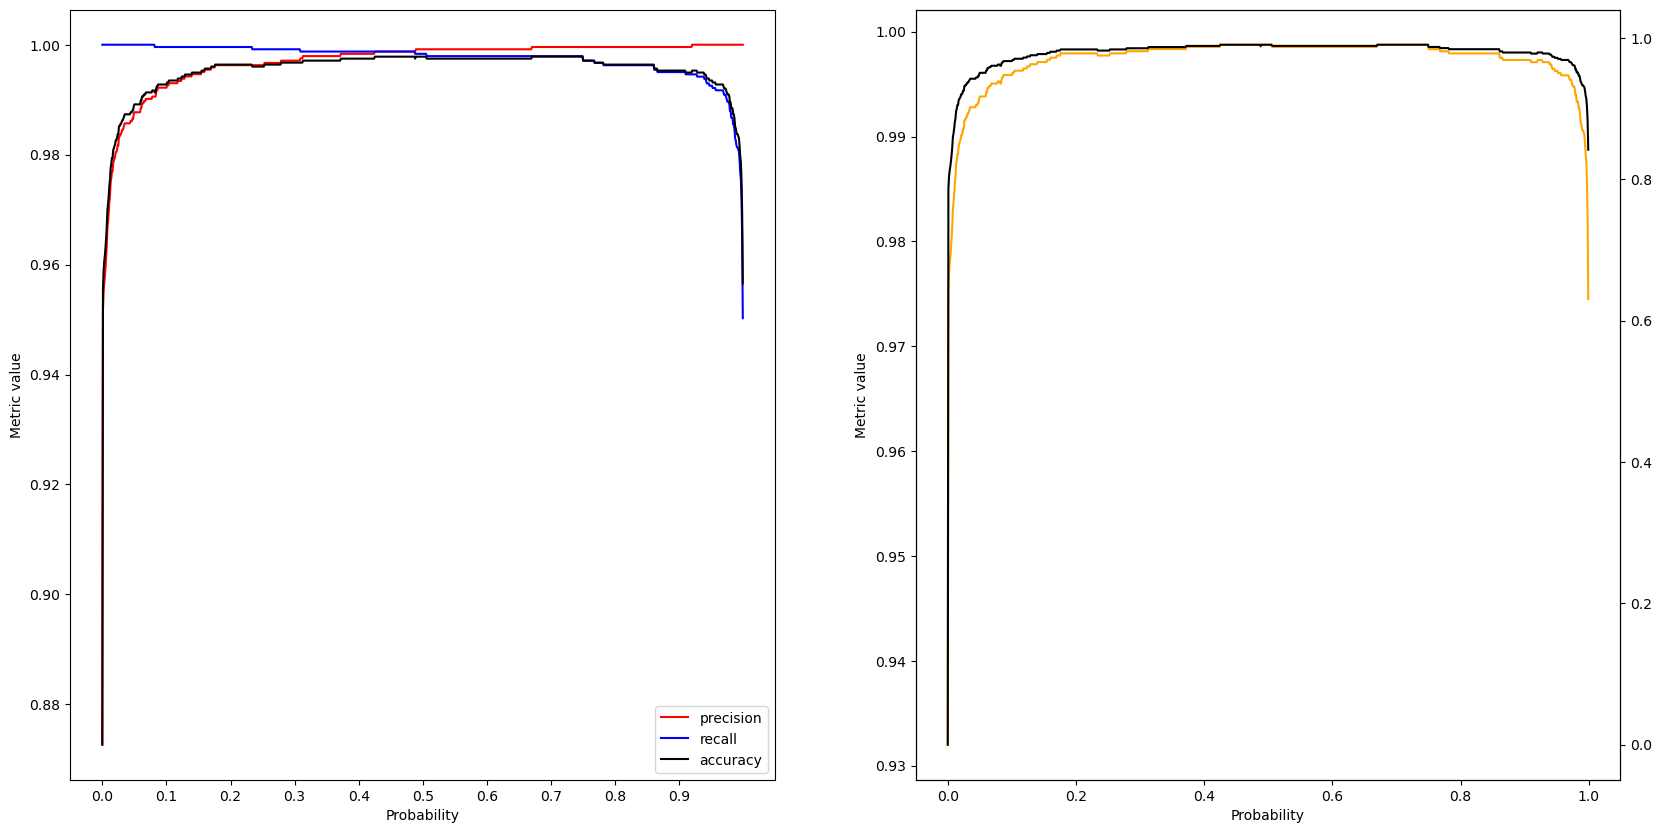

In [43]:
p, precision, recall, accuracy, f1score, mcc = classifier_performance(1000, tanh_val_predictions, val_lab)
plot_performance(p,precision,recall,accuracy,f1score, mcc)

In [44]:
print('Accuracy: ', max(accuracy), np.argmax(accuracy))
print('F1 score: ', max(f1score), np.argmax(f1score))
print('MCC: ', max(mcc), np.argmax(mcc))

Accuracy:  0.9978292329956585 425
F1 score:  0.9987562189054726 425
MCC:  0.9903014450092319 670


In [45]:
recall[1]

1.0

In [46]:
precision[990]

1.0

In [47]:
mcc[500]

0.9902623530956935

In [48]:
print('Precision: ', max(precision), np.argmax(precision))

Precision:  1.0 920


In [49]:
tanh_model.save('Case1_slle')

INFO:tensorflow:Assets written to: Case1_slle\assets


INFO:tensorflow:Assets written to: Case1_slle\assets
